# Taylor Swift Lyrics Analysis (in progress)

## Introduction

Taylor Swift is largely regarded as one of, if not the most well known female popstars of the 21st century, with a plethora of awards and record breaking tracks and albums. She is a household name, and one whose musical themes of love, relationships, and heartbreak have become a cornerstone of popular culture with the younger generations. 

Personally, I started listening to Taylor Swift again with the release of her most recent album *Red (Taylor's Version)*. This prompted me to listen to more of her discography, and I was surprised by how much she had changed as a person and songwriter from her first album in 2006 to her most recent. In this analysis, I want to gain more insight in to how Taylor Swift's songwriting abilities have changed from 2006 to now: **Is there an obvious difference in her storytelling abilities between 2006 and her recent albums? How has her transition from country to pop influenced her songwriting? What are the core themes of Taylor Swift's albums and how have they changed over the course of her career?**

To answer these questions, I will be analyzing a Kaggle dataset containing Taylor Swift's lyrics from her 2006 freshman album, *Taylor Swift* to her last album in 2020, *evermore (deluxe version)*.

## Data Pre-processing

As with any form of textual data, there will be words that do not add any value to the analysis or punctuation that hinders the analysis process, both of which should be removed. I have written functions to create a version of the lyrics with punctuation removed to create a table of general statistics of interest, and functions that remove both stopwords and punctuation from the lyrics in order to generate word clouds.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michealalexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# read in the data (9 albums)
taylor_swift = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/01-taylor_swift.csv')
fearless = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/02-fearless_taylors_version.csv')
speak_now = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/03-speak_now_deluxe_package.csv')
red = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/04-red_deluxe_edition.csv')
nineteen = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/05-1989_deluxe.csv')
reputation = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/06-reputation.csv')
lover = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/07-lover.csv')
folklore = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/08-folklore_deluxe_version.csv')
evermore = pd.read_csv('/Users/michealalexander/Desktop/taylor_swift_data/09-evermore_deluxe_version.csv')

In [3]:
albums = [taylor_swift, fearless, speak_now, red, nineteen, reputation, lover, folklore, evermore]

all_ts_albums = pd.concat(albums) # combine all albums into one dataframe

In [4]:
album_names = all_ts_albums['album_name'].unique() # store the album_names

In [5]:
album_names

array(['Taylor Swift', 'Fearless (Taylor’s Version)',
       'Speak Now (Deluxe)', 'Red (Deluxe Edition)', '1989 (Deluxe)',
       'reputation', 'Lover', 'folklore (deluxe version)',
       'evermore (deluxe version)'], dtype=object)

In [6]:
def remove_punctuation(text): # a small function to remove punctuation and lowercase words for brief analysis 
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text.lower()

In [7]:
# Apply to the DF series
all_ts_albums['lyrics_no_punc'] = all_ts_albums['lyric'].apply(remove_punctuation)

In [33]:
english_stop_words = set(stopwords.words("english"))

# added my own stop words based on scanning of lyrics, mostly removing runs of notes like 'ooh's and 'aah's
# as well as words that I determined would not be meaningful to analyze

my_stop_words = ['like','cause', 'im', 'got', 'oh', 
                 'ooh', 'ah', 'di', 'ra', 'it', 'fore', 'aah' ,'eh', 'eeh', 'da', 'na', 'Eh', 're', "i'll", 'mm'] 
for i in my_stop_words:
    english_stop_words.add(i)

In [9]:
def lyric_cleaning(lyrics): # a function to remove punctuation and stop words from a string in a specific order
    lyrics = lyrics.replace(',','')
    lyrics = lyrics.replace('-',' ')
    lyrics = lyrics.replace('(',' ')
    lyrics = lyrics.replace(')',' ')
    lyrics = lyrics.replace('"',' ')
    first_lower = [word.lower() for word in lyrics.split() if word.lower() not in english_stop_words]    
    remove_punc = ' '.join(first_lower)
    split_punc = remove_punc.split("'")
    reassemble = ' '.join(split_punc)
    remove_stop_again = [word.lower() for word in reassemble.split() if word.lower() not in english_stop_words]
    punc_removed_again = [char for char in remove_stop_again if char not in string.punctuation]
    reassemble_second = ' '.join(punc_removed_again)
    final_punc = [char for char in reassemble_second if char not in string.punctuation]
    final_join = ''.join(final_punc)

    return final_join

In [10]:
# create a column for lyrics with stop words and puncutation removed
all_ts_albums['lyrics_cleaned'] = all_ts_albums.lyric.apply(lyric_cleaning)

In [11]:
all_ts_albums.head(10)

,album_name,track_title,track_n,lyric,line,lyrics_no_punc,lyrics_cleaned
0,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,he said the way my blue eyes shined,said way blue eyes shined
1,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,put those georgia stars to shame that night,put georgia stars shame night
2,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,i said thats a lie,said lie
3,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,just a boy in a chevy truck,boy chevy truck
4,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,that had a tendency of gettin stuck,tendency gettin stuck
5,Taylor Swift,Tim McGraw,1,On back roads at night,6,on back roads at night,back roads night
6,Taylor Swift,Tim McGraw,1,And I was right there beside him all summer long,7,and i was right there beside him all summer long,right beside summer long
7,Taylor Swift,Tim McGraw,1,And then the time we woke up to find that summ...,8,and then the time we woke up to find that summ...,time woke find summer gone
8,Taylor Swift,Tim McGraw,1,But when you think Tim McGraw,9,but when you think tim mcgraw,think tim mcgraw
9,Taylor Swift,Tim McGraw,1,I hope you think my favorite song,10,i hope you think my favorite song,hope think favorite song


## Creating Summary Statistics

I would like to see how many words and unique words Taylor Swift uses in her albums and how that changes over the course of her career. The amount of words in and of itself cannot tell us directly how her songwriting has changed, but we can safely assume that as Swift grew up, she should have had more experiences to write about. Her growth as an artist and song writer should also allow her to convey more complex stories through her songs with less reptition of choruses or words. However, the amount of songs on each album must also be taken into account. 

In [12]:
# a function to split the lyrics into separate words and store them as a list 
def create_word_list(album_df, album_name_columns, album_title, lyric_column):
    word_list = []
    df = album_df[album_df[album_name_columns] == album_title]
    for line in df[lyric_column].str.split():
        for word in line:
            word_list.append(word)
    return word_list

In [13]:
# a function that creates a list of unique words from the submitted list
def create_unique_list(list): 
    unique_words = [] 
    for word in list:
        if word not in unique_words:
            unique_words.append(word)
    return unique_words

In [14]:
def max_tracks(album_df, album_name_columns, album_title, track_column):
    df = album_df[album_df[album_name_columns] == album_title]
    return max(df[track_column])

In [15]:
track_counts = []
song_word_counts = []
song_unique_word_counts = []

for ts_album in album_names:
    track_counts.append(max_tracks(all_ts_albums, 'album_name', ts_album, 'track_n'))
    all_word_list = create_word_list(all_ts_albums, 'album_name', ts_album, 'lyric')
    song_word_counts.append(len(all_word_list)) # store number of words in each album in a list
    unique_words = create_unique_list(all_word_list) # create unique word list of the album
    song_unique_word_counts.append(len(unique_words))

In [16]:
taylor_swift_df_stats = pd.DataFrame({'Album Name': album_names, 
                                      'Tracks': track_counts,
                                      'Total Words': song_word_counts,
                                      'Unique Words':song_unique_word_counts})

In [17]:
taylor_swift_df_stats['Total Words:Unique Words'] = taylor_swift_df_stats['Total Words']/taylor_swift_df_stats['Unique Words']
taylor_swift_df_stats['Average Number of Words per Song'] = taylor_swift_df_stats['Total Words']/taylor_swift_df_stats['Tracks']

In [18]:
taylor_swift_df_stats

,Album Name,Tracks,Total Words,Unique Words,Total Words:Unique Words,Average Number of Words per Song
0,Taylor Swift,15,4286,818,5.239609,285.733333
1,Fearless (Taylor’s Version),26,8809,1382,6.374096,338.807692
2,Speak Now (Deluxe),17,6875,1326,5.184766,404.411765
3,Red (Deluxe Edition),22,7364,1273,5.784760,334.727273
4,1989 (Deluxe),16,7186,1193,6.023470,449.125000
5,reputation,15,7236,1318,5.490137,482.400000
6,Lover,18,6763,1395,4.848029,375.722222
7,folklore (deluxe version),17,5124,1310,3.911450,301.411765
8,evermore (deluxe version),17,6009,1369,4.389335,353.470588


## Summary Statistic Observations

Now that we have some statistics about Taylor Swift's music, we can make several observations: 

- Swift's first album (*Taylor Swift*) is her shortest album in terms of tracks and total words and unique words used.
- Swifts longest album at this point is *Fearless (Taylor's Version)* (a re-release of *Fearless* containing several vault tracks that were not included on the first album) with 26 songs and ~8800 words. However it has the highest ratio of total words to unique words among her discography.
- The number of tracks per album generally decreases after the release of *Red*.
- The album with the lowest ratio between total words and unique words is *folklore*.
- *Reputation* has the highest average number of words per song even though it has the lowest number of tracks compared to her other albums.

These observations provide some interesting insight as to how Taylor Swift's songwriting has changed over the past decade and a half. Unsurprisingly, her first album has the fewest number of tracks and total/unique words used, with a moderately high ratio between the number of total words and unique words. Unique words used (or lack thereof) don't implicitly indicate a lack of skill in songwriting, but it is a good baseline to establish and use when looking at her other albums. 

Comparing this to the last 2 albums in this dataset, the ratio decreases considerably, with the lowest ratio in *folklore* and only slightly higher in *evermore*. These albums were considered a steep departure from her normal types of songs by both fans and music critics. The albums were written during the height of the pandemic and lockdowns, giving her plenty of new themes to write about in conjunction with her own experiences.

In general we can see that Taylor is producing more songs and using more words as her career continues, but as of recently, she is using more unique words relative to the total vocabulary of her songs, which could indicate an increased precision and complexity in her songwriting.

# Creating Word Clouds

To obtain a better understanding of the themes in Taylor Swift's albums, I chose to conduct a word cloud analysis.  Since I am also interested in how her song writing has changed over time, I wanted to compare word clouds for her different albums, specifically comparing her first album (*Taylor Swift*), last album (*evermore*), and an album near the middle of her career (*Red*). Since she considered herself a country artist at the beginning of her career and has since transitioned to writing pop music, I am curious to see how pronounced the change is between themes.

I wrote a specific function to clean the lyrics by removing stop words and punctuation. I noticed that in Python's english set of stop words, some contractions are split into two parts (i.e the set does not have "that's" but rather "that" and "s") which meant I needed to split some of the lyrics, remove the punctuation, and rejoin them multiple times.

In [34]:
# this function creates a cleaned version of the lyrics column for the album that is passed through
# which is necessary for 
def create_clean_album(album_df, album_name_columns, album_title, lyric_column):
        df = album_df[album_df[album_name_columns] == album_title]
        lyric_df = df[lyric_column].apply(lyric_cleaning)
        lyrics = ' '.join(lyric_df)
        return lyrics

# create the corpus of processed lyrics for all 9 albums
all_album_clean_lyrics = []
for album in album_names:
    cleaned_lyrics = create_clean_album(all_ts_albums, 'album_name', album, 'lyric')
    all_album_clean_lyrics.append(cleaned_lyrics)

I decided to use  TFIDF feature extraction for my word cloud analysis to identify more meaningful words/features for each album than a simple word count aggregation, especially since I want to compare words across all albums. 

In [20]:
# this function creates the word cloud given the text corpus and album name of interest
def create_word_cloud(corpus, album_name):
    vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df = 0.7, min_df = .01) # initialize TFIDF vectorizer
    X = vectorizer.fit_transform(corpus) # fit the model
    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    
    data = df.transpose()
    data.columns = album_names

    wordcloud = WordCloud(width=3000, height=2000, max_words=500).generate_from_frequencies(data[album_name])
    plt.figure(figsize=[15,10])
    plt.imshow(wordcloud)

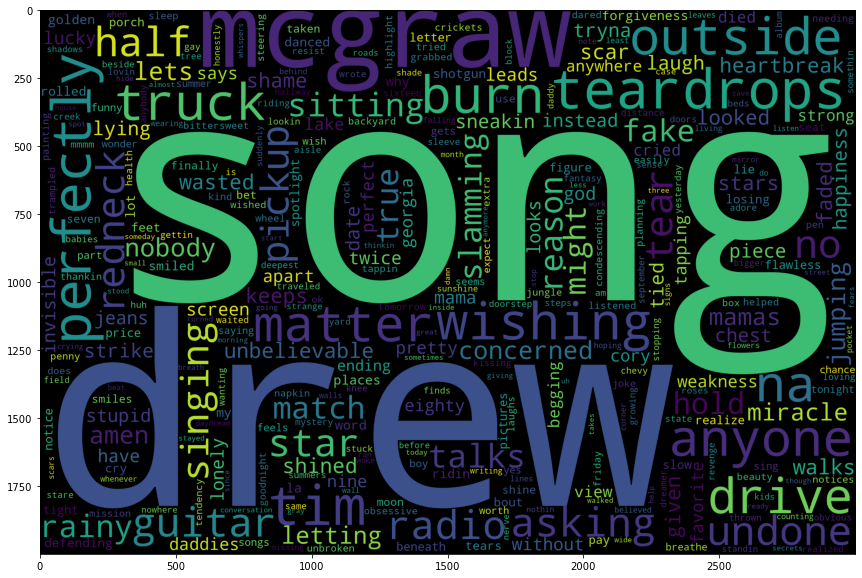

In [55]:
create_word_cloud(all_album_clean_lyrics, 'Taylor Swift')

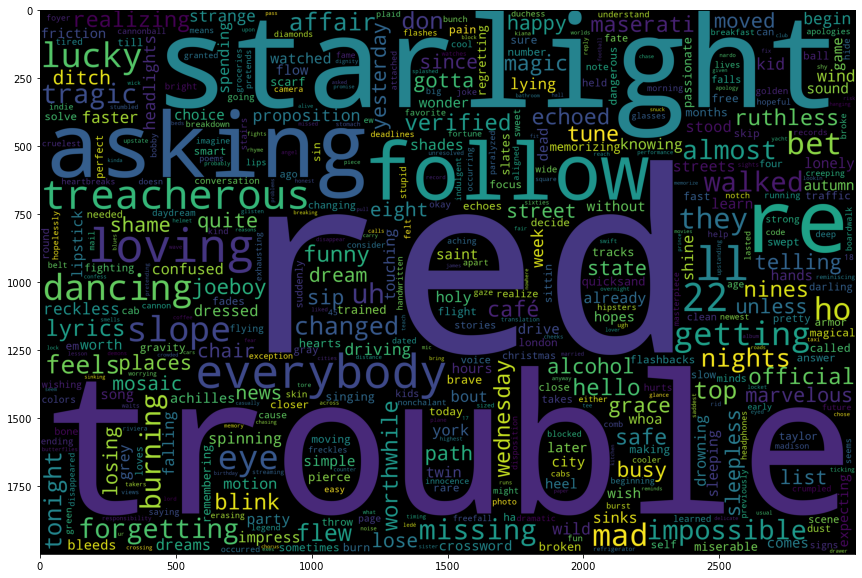

In [35]:
create_word_cloud(all_album_clean_lyrics, 'Red (Deluxe Edition)')

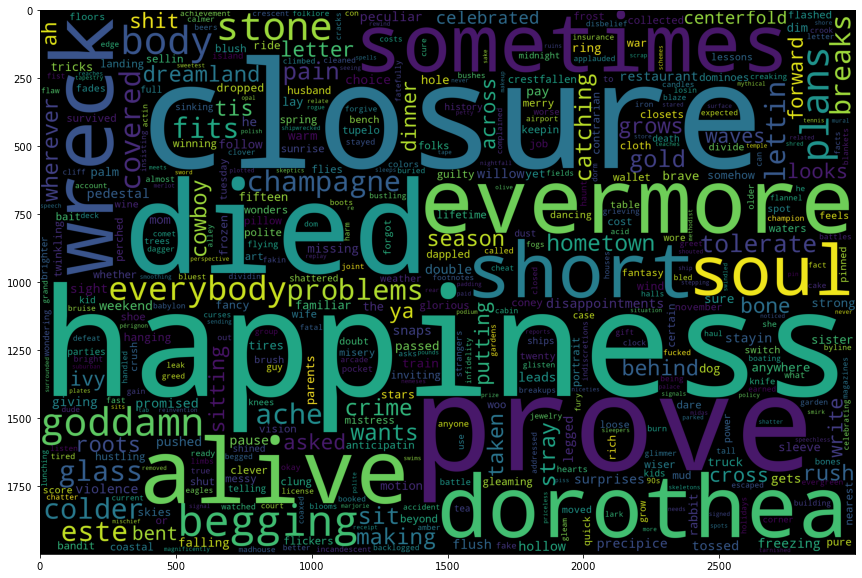

In [46]:
create_word_cloud(all_album_clean_lyrics, 'evermore (deluxe version)')

Now that we have word clouds for three of Taylor Swift's albums, we can see right away that the most meaningful words in each album vary quite greatly. The top 15 most meaningful words according to the TFIDF model are as follows: 

- *Taylor Swift*: 'song', 'drew', 'tim', 'teardrops', 'mcgraw', 'perfectly', 'burn', 'wishing', 'anyone', 'outside', 'truck', 'matter', 'drive', 'guitar', 'half'
- *Red*: 'red', 'trouble', 'starlight', 'asking', 'follow', 'everybody', 'loving', 'treacherous', '22', 'dancing', 'slope', 'lucky', 'eye', 'getting', 'mad'
- *evermore*: 'happiness', 'prove', 'closure', 'died', 'evermore', 'alive', 'wreck', 'dorothea', 'sometimes', 'short', 'soul', 'begging', 'yes', 'dead', 'goddamn', 'stone', 'plans', 'body'

In her first album, we find words that show Taylor likely had an idyllic and somewhat naive view of love which was shattered upon having her first romantic relationships ("teardrops", "burn", "wishing"). It is also obvious that she is still in her country era with words like "guitar", "truck", "drive", being common, and mentions of "Tim Mcgraw", another famous country singer. In general, these are themes we would expect of a teenage artist who is forging her own path in the world and having new life experiences.

By the time *Red* is written, Taylor has had several high profile relationships and is well known for her catchy and revenge-like breakup tracks. By looking at the prevalent words in *Red* we can see that she has a mixed view of her relationships and love in general; "starlight", "dancing", and "loving"  could show the positive aspects of Swift's relationships while "trouble", "treacherous", "slope" and "mad" show some of the struggles she's had in this area. Like in her debut album, she is still clearly writing about love, but here she offers more depth into what her romantic life has been like.

Lastly, *evermore* diverges completely from both of these albums in terms of themes and style, largely avoiding the topic of love entirely. With words like "closure", "died", "soul", "wreck", "begging" Swift is clearly writing about darker and more mature topics. This makes sense as the album was written in the midst of the pandemic before vaccines were widely available and people all over the world were stuck in their homes. Taylor Swift herself said that these albums weren't necessarily about herself and her experiences but an opportunity for her to write stories and create intricate characters that resonated with her audience. Here, Swift displays her maturity and versatility as a songwriter and artist, assuming an almost completely different thematic voice compared to the other two albums.

# Conclusion

**Is there an obvious difference in her storytelling abilities between 2006 and her recent albums? How has her transition from country to pop influenced her songwriting? What are the core themes of Taylor Swift's albums and how have they changed over the course of her career?**

Overall, by looking at the contents of Taylor Swift's lyrics, we can see how her songwriting and the themes she writes about have evolved over the course of her career. Compared to her very first album, Swift uses many more unique words in her recent albums; this could be indicative of an experienced songwriter who has greater control and awareness of the words she uses and how she conveys her feelings. Her transition from writing and performing country music to pop music is also clear after this analysis. Not only was she a younger artist during her country era, but the topics she wrote about expanded greatly after she became a pop artist. Country music has very defined themes, mostly pertaining to love while writing pop music allowed Swift to pull inspiration from different parts of her life beyond her romantic relationships (friends, coming of age, world events). Over the course of her career, we definitely see a recurring theme of love and romance, but the way that Swift is able to convey her experiences and struggles through her song writing gets more specific with each album. With *evermore*, she is able to completely change her songwriting voice, which results in a haunting and dark narrative that matches the atmosphere, tragedy, and complexity of living through a world wide pandemic. 

Although Taylor Swift's music is not for everyone, it is hard to deny she is one of the best song writers of her generation, and one whose growth as an individual and artist is captured so intimitately through her discography.